Text(0.5, 0, 'poverty')

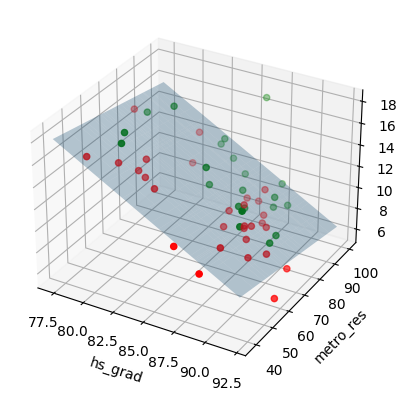

: 

In [4]:
# 3D визуализация зависимости бедности от hs_grad и metro_res с добавлением плоскости нашей регрессионной модели (Python):

import statsmodels.formula.api as smf
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

data = pd.read_csv('http://d396qusza40orc.cloudfront.net/statistics/lec_resources/states.csv')

data.head()

lm = smf.ols(formula='poverty ~ metro_res + hs_grad', data=data).fit()

lm.params

def f(x, y):
    return lm.params.Intercept + lm.params.hs_grad * x  + lm.params.metro_res * y

x = data.hs_grad.sort_values()
y = data.metro_res.sort_values()

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.3)
data_below_serf = data[data['poverty'] < f(data['hs_grad'], data['metro_res'])]
data_above_serf = data[data['poverty'] >= f(data['hs_grad'], data['metro_res'])]
ax.scatter(data_below_serf.hs_grad, data_below_serf.metro_res, data_below_serf.poverty, c='r', marker='o')
ax.scatter(data_above_serf.hs_grad, data_above_serf.metro_res, data_above_serf.poverty, c='g', marker='o')
ax.set_xlabel('hs_grad')
ax.set_ylabel('metro_res')
ax.set_zlabel('poverty')

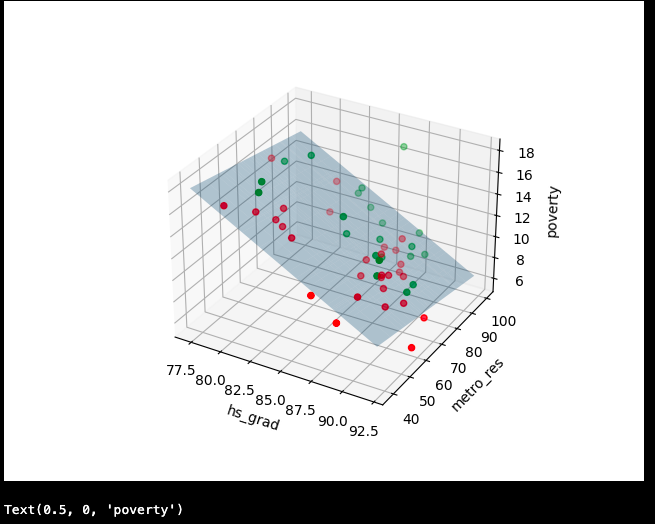

In [5]:
# расчет всех показателей для многофакторного анализа взаимосвязи зависимой переменной "УРОВЕНЬ БЕДНОСТИ" с независимыми:
#- процент жителей столиц
#- процент белых жителей
#- процент жителей со средним образованием
#- процент домохозяек

import pandas as pd
import statsmodels.formula.api as sm
data = pd.read_csv('http://d396qusza40orc.cloudfront.net/statistics/lec_resources/states.csv')
result = sm.ols(formula="poverty ~ metro_res + white + hs_grad + female_house", data=data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                poverty   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     20.58
Date:                Sat, 29 Oct 2022   Prob (F-statistic):           8.88e-10
Time:                        13:53:29   Log-Likelihood:                -103.39
No. Observations:                  51   AIC:                             216.8
Df Residuals:                      46   BIC:                             226.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       66.4765     12.590      5.280   

In [7]:
# А ВОТ ЧТО БУДЕТ, ЕСЛИ УДАЛИТЬ МЕШАЮЩУЮ НАМ ПЕРЕМЕННУЮ женщин-домохозяек (т.к она мульколлинеарна с другими НП)

# расчет всех показателей для многофакторного анализа взаимосвязи зависимой переменной "УРОВЕНЬ БЕДНОСТИ" с независимыми:
#- процент жителей столиц
#- процент белых жителей
#- процент жителей со средним образованием


import pandas as pd
import statsmodels.formula.api as sm
data = pd.read_csv('http://d396qusza40orc.cloudfront.net/statistics/lec_resources/states.csv')
result = sm.ols(formula="poverty ~ metro_res + white + hs_grad ", data=data).fit()
print(result.summary())



                            OLS Regression Results                            
Dep. Variable:                poverty   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     28.00
Date:                Sat, 29 Oct 2022   Prob (F-statistic):           1.55e-10
Time:                        18:37:22   Log-Likelihood:                -103.41
No. Observations:                  51   AIC:                             214.8
Df Residuals:                      47   BIC:                             222.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.7220      6.389     10.756      0.0

In [12]:
# Параллельная проверка независимых переменных на мульколлинеарность - поиск максимального Adj R-squared

df = pd.read_csv('http://d396qusza40orc.cloudfront.net/statistics/lec_resources/states.csv')

# Найдём такой набор фичей, что R-squared максимальна
feats = {'metro_res', 'white', 'hs_grad', 'female_house'}

# Рекурсивно переберём все сочетания переменных
def brute_force(params: set, formula: str, result: set) -> str:
    if not params:
        result.add(formula.lstrip('+ '))
        return 
    else:
        new_params = params.copy()
        for el in params:
            new_params.remove(el)

            brute_force(new_params, formula + ' + ' + el, result)
            brute_force(new_params, formula, result)

res = set()          
brute_force(feats, '', res)
res.remove('')

# Теперь посчитаем Adjusted R-Square для каждого сочетания и выведем на экран
for formula in res:
    lm = smf.ols(formula='poverty ~ ' + formula, data=df).fit()
    print(f'{lm.rsquared_adj:.2}', formula)

0.55 female_house + hs_grad + white
0.26 female_house
0.61 female_house + hs_grad + metro_res + white
0.6 female_house + hs_grad + metro_res
0.4 female_house + metro_res
0.17 metro_res + white
0.022 metro_res
0.55 hs_grad
0.077 white
0.39 female_house + metro_res + white
0.26 female_house + white
0.62 hs_grad + metro_res + white
0.56 hs_grad + white
0.55 female_house + hs_grad
0.58 hs_grad + metro_res


<IPython.core.display.Javascript object>


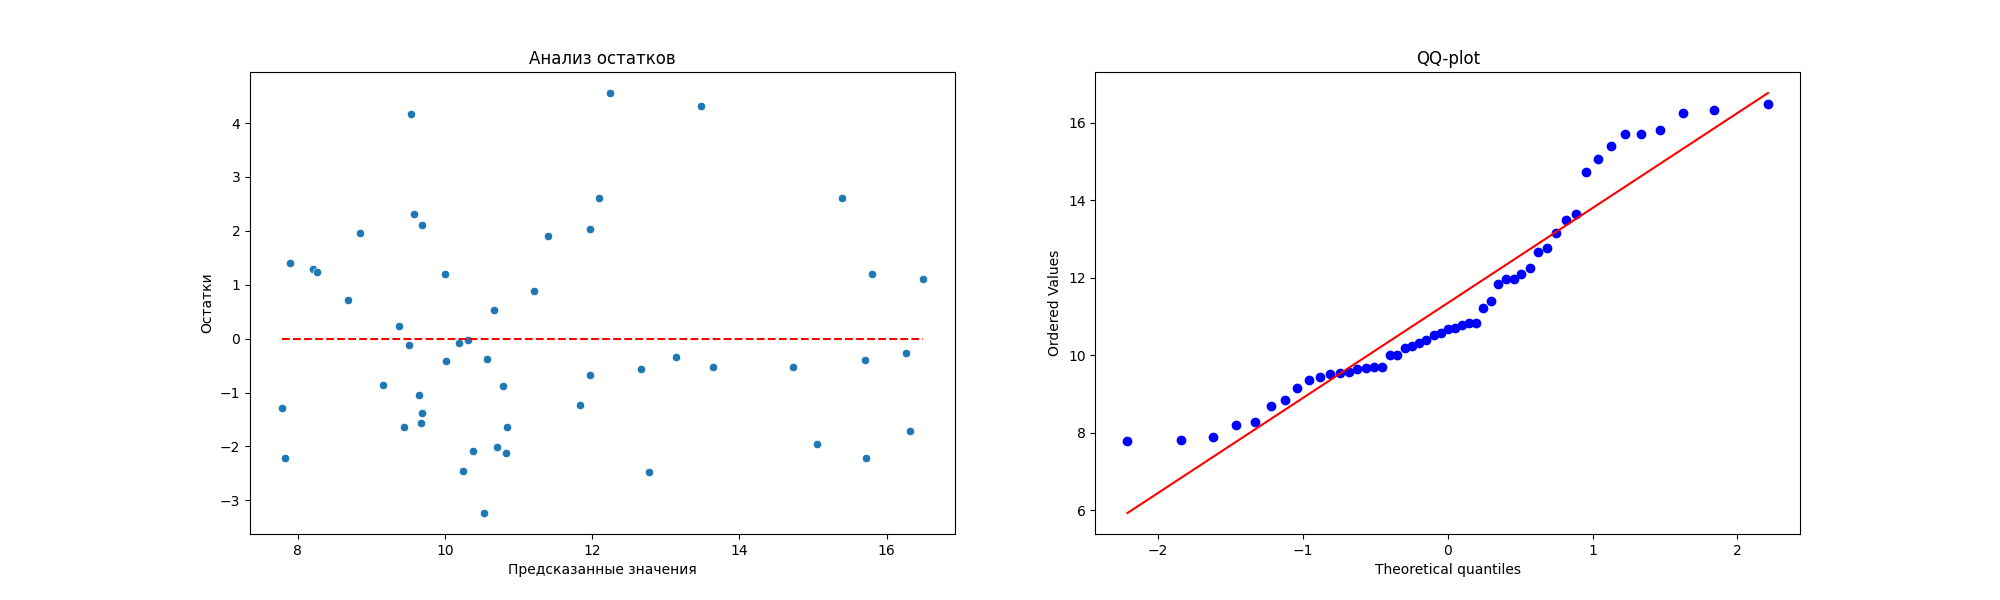

Text(0.5, 1.0, 'QQ-plot')

In [21]:
# выведем построение графиков для оценки гетероскедастичности остатков и их нормальности распределения

import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


data = pd.read_csv('http://d396qusza40orc.cloudfront.net/statistics/lec_resources/states.csv')

# Коэффициенты уравнения регрессионной модели
params = sm.ols(formula="poverty ~ metro_res + white + hs_grad", data=data).fit().params
params


# Предсказанные значения (значения из DataFrame -> уравнение регресионной модели) 
y = params[0] + params[1] * data['metro_res'] + params[2] * data['white'] + params[3] * data['hs_grad'] 
# Вычисление остатка с помощью библиотеки statsmodels.formula.api - sm
# Остатки - на сколько y далека от теоретической модели
residuals = sm.ols(formula="poverty ~ metro_res + white + hs_grad", data=data).fit().resid
# residuals = data['poverty'] - y - то же самое
# Создаем графики
figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
# Scatter plot
plt.sca(ax1)
sns.scatterplot(x=y, y=residuals)
sns.lineplot(x=y, y=0, linestyle='--', color='r')
plt.title('Анализ остатков')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')

#QQ-plot
plt.sca(ax2)
stats.probplot(y, plot=sns.mpl.pyplot)
plt.title('QQ-plot')